In [1]:
import numpy as np
import pandas as pd
import joblib
import re
import torch
import random
import torch.nn as nn
import transformers
import matplotlib.pyplot as plt
import json
from tensorflow.keras import layers , activations , models , preprocessing, utils
from transformers import AutoModel, BertTokenizerFast
from torch import save
import warnings
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
warnings.filterwarnings("ignore")

# Reading the data

The dataset used is the Chatterbot dataset provided by Kaggle. The data is in the format of `yml` having question and answer pairs on various subjects like science, history, and psychology.

In [2]:
with open('train.json', 'r') as f:
    data = json.load(f)

In [3]:
data

[{'context': 'The bot may answer Hey, Hello, thanks for visiting, Hi there, what can I do for you?, Hi there, how can I help you when the user greets the bot.',
  'qas': [{'id': '00001',
    'is_impossible': False,
    'question': 'Hi',
    'answers': [{'text': 'Hey', 'answer_start': 19}]},
   {'id': '00002',
    'is_impossible': False,
    'question': 'Hello',
    'answers': [{'text': 'Hi there, what can I do for you?',
      'answer_start': 52}]},
   {'id': '00003',
    'is_impossible': False,
    'question': 'yow',
    'answers': [{'text': 'Hi there, how can I help you?',
      'answer_start': 86}]}]},
 {'context': 'The bot may answer: See you later, thanks for visiting; Have a nice day.; or Bye! Come back again soon when the user goodbye to the bot.',
  'qas': [{'id': '00004',
    'is_impossible': False,
    'question': 'Bye',
    'answers': [{'text': 'See you later', 'answer_start': 20}]},
   {'id': '00005',
    'is_impossible': False,
    'question': 'Goodbye',
    'answers': [{'

In [4]:
data[5].keys()

dict_keys(['context', 'qas'])

In [5]:
data[5]['qas']

[{'id': '00013',
  'is_impossible': False,
  'question': 'How to apply scholarship for COAHS and graduate program students',
  'answers': [{'text': 'For COAHS and Graduate Program Students: <br>  The Scholarship Application Form has been made available via the UMak Online Encoding and Assessment (OLEA) website. Please be guided by the following procedures: <br> 1. Download the Scholarship Application Form via the link provided. Take note of the required documents specified. <br> 2. Print the Scholarship  Application Form in a LONG (8.5 x 13) size bond paper and fill-out the necessary details. <br> 3. Proceed to Room 202, Academic Building 2 and submit the duly endorsed (please refer to the list of requirements regarding the Endorsing College/Office/Officer) and accomplished Scholarship Application Form together with the other requirements (in triplicate copies).',
    'answer_start': 1}]}]

In [6]:
data[5]['context']

'For COAHS and Graduate Program Students: <br>  The Scholarship Application Form has been made available via the UMak Online Encoding and Assessment (OLEA) website. Please be guided by the following procedures: <br> 1. Download the Scholarship Application Form via the link provided. Take note of the required documents specified. <br> 2. Print the Scholarship  Application Form in a LONG (8.5 x 13) size bond paper and fill-out the necessary details. <br> 3. Proceed to Room 202, Academic Building 2 and submit the duly endorsed (please refer to the list of requirements regarding the Endorsing College/Office/Officer) and accomplished Scholarship Application Form together with the other requirements (in triplicate copies).'

In [7]:
data[10]['qas'][2]['question']

'How to pay the token fee?'

In [8]:
len(data)

14

In [9]:
questions, answers = [], []

for i in range(len(data)):
    for j in range (len(data[i]['qas'])):
        questions.append(data[i]['qas'][j]['question'])
        answers.append(data[i]['qas'][j]['answers'][0]['text'])
 

In [10]:
len(questions), len(answers)

(102, 102)

In [14]:
dictionary = {'text' : questions, 'label' : answers}

In [15]:
df = pd.DataFrame(dictionary)
df.head()

,text,label
0,Hi,Hey
1,Hello,"Hi there, what can I do for you?"
2,yow,"Hi there, how can I help you?"
3,Bye,See you later
4,Goodbye,thanks for visiting


In [16]:
# Converting the labels into encodings
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
# check class distribution
df['label'].value_counts(normalize = True)

15    0.715686
11    0.039216
7     0.039216
8     0.029412
1     0.019608
12    0.019608
16    0.019608
0     0.009804
14    0.009804
9     0.009804
4     0.009804
6     0.009804
2     0.009804
17    0.009804
3     0.009804
18    0.009804
10    0.009804
5     0.009804
13    0.009804
Name: label, dtype: float64

In [17]:
joblib.dump(le, 'le')

['le']

In [18]:
train_text, train_labels = df['text'], df['label']

# Building the Model

In [19]:
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# Import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


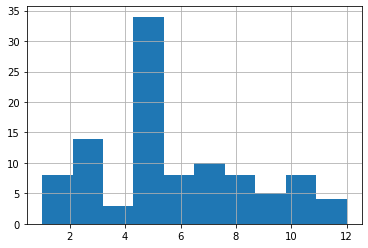

In [20]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 10)
# Based on the histogram we are selecting the max len as 11
max_seq_len = 11

In [21]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

In [22]:
joblib.dump(tokenizer, 'tokenizer')

['tokenizer']

In [23]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

In [24]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#define a batch size
batch_size = 16
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# DataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [25]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):      
        super(BERT_Arch, self).__init__()
        self.bert = bert 
      
        # dropout layer
        self.dropout = nn.Dropout(0.2)
      
        # relu activation function
        self.relu =  nn.ReLU()
        # dense layer
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,19)
        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)
        #define the forward pass
    def forward(self, sent_id, mask):
        #pass the inputs to the model  
        cls_hs = self.bert(sent_id, attention_mask=mask)[0][:,0]
      
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
      
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        # output layer
        x = self.fc3(x)
   
        # apply softmax activation
        x = self.softmax(x)
        return x
# freeze all the parameters. This will prevent updating of model weights during fine-tuning.
for param in bert.parameters():
      param.requires_grad = False
model = BERT_Arch(bert)


In [26]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
BERT_Arch                                               --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─Embedding: 3-3                              (1,536)
│    │    └─LayerNorm: 3-4                              (1,536)
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             (85,054,464)
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 (590,592)
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─ReLU: 1-3                                             --
├─Linea

In [27]:
from transformers import AdamW
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [28]:
np.unique(train_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

In [29]:
from sklearn.utils.class_weight import compute_class_weight
#compute the class weights
class_wts = compute_class_weight('balanced', classes  = np.unique(train_labels), y = train_labels)
print(class_wts)

[5.36842105 2.68421053 5.36842105 5.36842105 5.36842105 5.36842105
 5.36842105 1.34210526 1.78947368 5.36842105 5.36842105 1.34210526
 2.68421053 5.36842105 5.36842105 0.07354001 2.68421053 5.36842105
 5.36842105]


In [30]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
#weights = weights.to(device)
# loss function
cross_entropy = nn.NLLLoss(weight=weights) 

In [31]:
from torch.optim import lr_scheduler
# empty lists to store training and validation loss of each epoch
train_losses=[]
# number of training epochs
epochs = 200
# We can also use learning rate scheduler to achieve better results
lr_sch = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [32]:
# function to train the model
def train():
  
    model.train()
    total_loss = 0
  
    # empty list to save model predictions
    total_preds=[]
  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step,    len(train_dataloader)))
    # push the batch to gpu
        #batch = [r.to(device) for r in batch] 
        sent_id, mask, labels = batch
        # get model predictions for the current batch
        preds = model(sent_id, mask)
        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)
        # add on to the total loss
        total_loss = total_loss + loss.item()
        # backward pass to calculate the gradients
        loss.backward()
        # clip the the gradients to 1.0. It helps in preventing the    exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update parameters
        optimizer.step()
        # clear calculated gradients
        optimizer.zero_grad()
  
        # We are not using learning rate scheduler as of now
        # lr_sch.step()
        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()
        # append the model predictions
        total_preds.append(preds)
    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    #returns the loss and predictions
    return avg_loss, total_preds

In [33]:
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    # append training and validation loss
    train_losses.append(train_loss)
    # it can make your experiment reproducible, similar to set  random seed to all options where there needs a random seed.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f'\nTraining Loss: {train_loss:.3f}')


 Epoch 1 / 200

Training Loss: 3.043

 Epoch 2 / 200

Training Loss: 2.893

 Epoch 3 / 200

Training Loss: 2.876

 Epoch 4 / 200

Training Loss: 2.802

 Epoch 5 / 200

Training Loss: 2.622

 Epoch 6 / 200

Training Loss: 2.384

 Epoch 7 / 200

Training Loss: 2.205

 Epoch 8 / 200

Training Loss: 1.908

 Epoch 9 / 200

Training Loss: 1.792

 Epoch 10 / 200

Training Loss: 1.823

 Epoch 11 / 200

Training Loss: 1.585

 Epoch 12 / 200

Training Loss: 1.528

 Epoch 13 / 200

Training Loss: 1.287

 Epoch 14 / 200

Training Loss: 1.233

 Epoch 15 / 200

Training Loss: 1.272

 Epoch 16 / 200

Training Loss: 1.316

 Epoch 17 / 200

Training Loss: 1.160

 Epoch 18 / 200

Training Loss: 0.918

 Epoch 19 / 200

Training Loss: 0.782

 Epoch 20 / 200

Training Loss: 0.901

 Epoch 21 / 200

Training Loss: 0.891

 Epoch 22 / 200

Training Loss: 0.748

 Epoch 23 / 200

Training Loss: 0.647

 Epoch 24 / 200

Training Loss: 0.781

 Epoch 25 / 200

Training Loss: 0.813

 Epoch 26 / 200

Training Loss: 0

In [34]:
#PATH = "./bert_model.pt"
#torch.save(model, PATH)

In [35]:
#model = torch.load('./bert_model.pt')
#save(model.state_dict(), PATH)

In [36]:
def get_prediction(str):
    str = re.sub(r'[^a-zA-Z ]+', '', str)
    test_text = [str]
    model.eval()

    tokens_test_data = tokenizer(
    test_text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
     )
    test_seq = torch.tensor(tokens_test_data['input_ids'])
    test_mask = torch.tensor(tokens_test_data['attention_mask'])

    preds = None
    
    preds = model(test_seq, test_mask)
    preds = preds.detach().cpu().numpy()
    print(preds)
    preds = np.argmax(preds, axis = 1)
    print(preds)
    #print('Response: ', le.inverse_transform(preds)[0])
    return le.inverse_transform(preds)[0]


In [37]:
get_prediction('How to enroll in cos')

[[-9.64163399e+00 -1.32032585e+01 -2.82814865e+01 -1.99680233e+01
  -2.28489227e+01 -2.37865467e+01 -1.94861469e+01 -2.69982796e+01
  -2.57331333e+01 -1.54346743e+01 -2.00021038e+01 -1.98701229e+01
  -2.36965199e+01 -1.89659348e+01 -1.51130867e+01 -7.42646298e-05
  -1.18827477e+01 -3.50550957e+01 -2.22672920e+01]]
[15]


'You need to register online at www.umak.edu.oh/olca/registration/new (for freshmen) or https://umak.edu.ph/olca/registration/new/transferee (for transferees) and fill out the application form.<br>After answering the CAPTCHA, Press submit the application form. <br>A verification email will be sent to the registered email of the applicant. Open the email address registered in the application form and check for verification email. Click "verify" button. <br> Another email will be sent containing a pre-filled application form, list of requirements, and the google link where admission requirements will be uploaded. <br>Submit the complete and clear scanned requirements, compiled in one pdf, in the Google link. Read carefully and follow the instructions in the link<br>\t1.Accomplished Application form <br>\t2.Four (4) copies of recent 2x2ID pictures (with name tag and white background) <br>\t3.Photocopy of Record Card/Transcript of Records <br>\t\t1.Grade 11 Report card (For current Grade 1

In [38]:
# Model Metrics

In [39]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        train_seq = torch.tensor(tokens_train['input_ids'])
        train_mask = torch.tensor(tokens_train['attention_mask'])

        # Compute logits
        with torch.no_grad():
            logits = model(train_seq, train_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

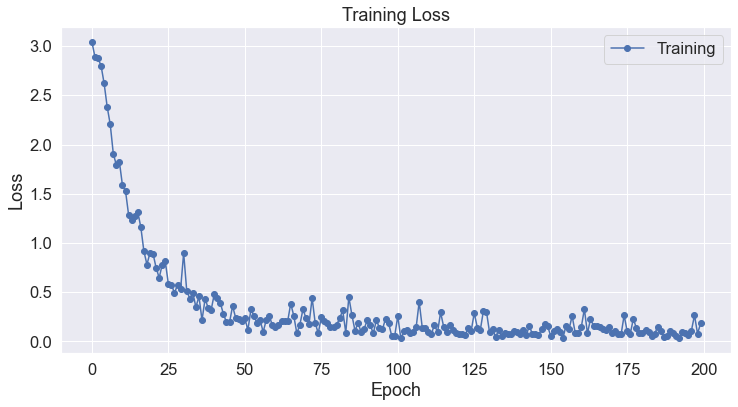

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')
# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(train_losses, 'b-o', label="Training")

# Label the plot.
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [41]:
preds = model(train_seq, train_mask)
preds = preds.detach().cpu().numpy()
preds = np.argmax(preds, axis = 1)

In [42]:
cm = confusion_matrix(train_labels, preds)

<AxesSubplot:>

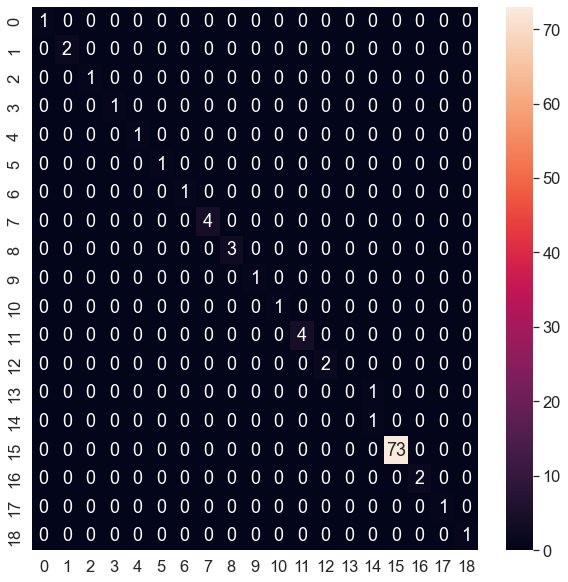

In [43]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot = True)

In [44]:
from sklearn.metrics import accuracy_score
accuracy_score(train_labels, preds)

0.9901960784313726

In [45]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(train_labels, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         2
          13       0.00      0.00      0.00         1
          14       0.50      1.00      0.67         1
          15       1.00      1.00      1.00        73
          16       1.00      1.00      1.00         2
          17       1.00    